# Intel Image Classification (CNN - Keras)

Hello, I hope you are having a great day.

In this notebook, I will try the process of implementing CNN with Keras in order to classify images.
1. Firstly, we'll import usefull packages.
1. Then, we'll load the data, before visualize and preprocess it.
1. We'll try a simple CNN model and then we will evaluate its performances.
1. We will then use pre trained model to address this challenge aswell.

# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [8]:
CURR_DIR_PATH = os.getcwd()

In [9]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    CURR_DIR_PATH = os.getcwd()
    datasets = [CURR_DIR_PATH + '/data/seg_train/seg_train', CURR_DIR_PATH + '/data/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [10]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading c:\Users\David Krylstedt\Documents\AW_Academy\Moduler\Graduation_project2\Graduation-project/data/seg_train/seg_train


100%|██████████| 2382/2382 [00:12<00:00, 195.27it/s]


Loading c:\Users\David Krylstedt\Documents\AW_Academy\Moduler\Graduation_project2\Graduation-project/data/seg_test/seg_test


100%|██████████| 501/501 [00:02<00:00, 191.50it/s]


In [11]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Let's explore the dataset
We can ask ourselves:
* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [13]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print (f"Number of training examples: {n_train}")
print (f"Number of testing examples: {n_train}")
print (f"Each image is of size: {IMAGE_SIZE}")

Number of training examples: 14034
Number of testing examples: 14034
Each image is of size: (150, 150)


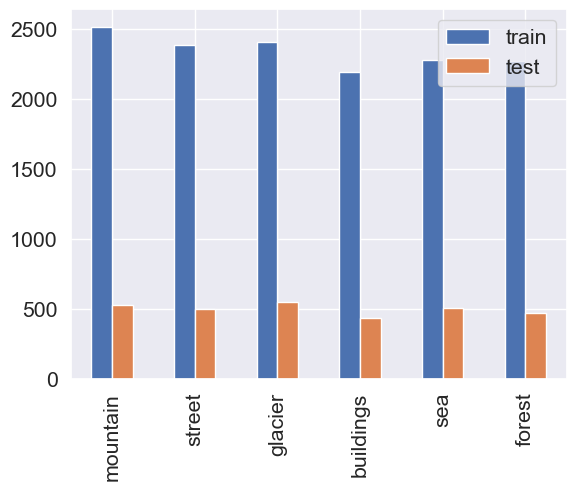

In [14]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

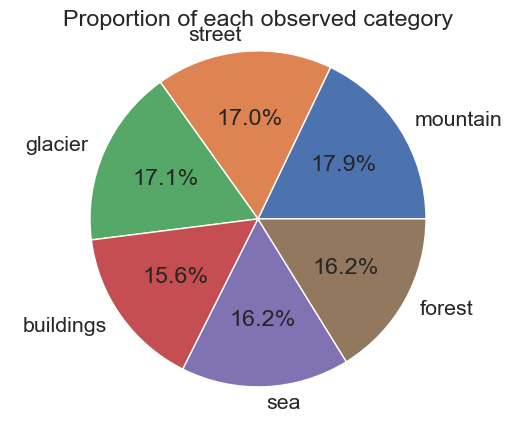

In [15]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Good practice: scale the data

In [16]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
We can display a random image from the training set.

In [17]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

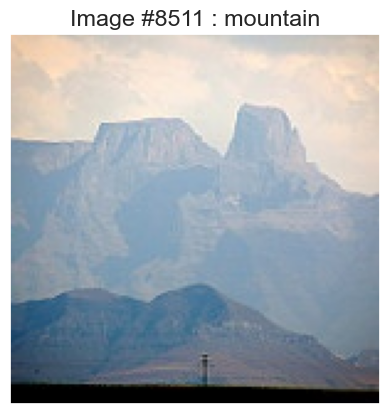

In [18]:
display_random_image(class_names, train_images, train_labels)

We can also display the first 25 images from the training set directly with a loop to get a better view

In [19]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

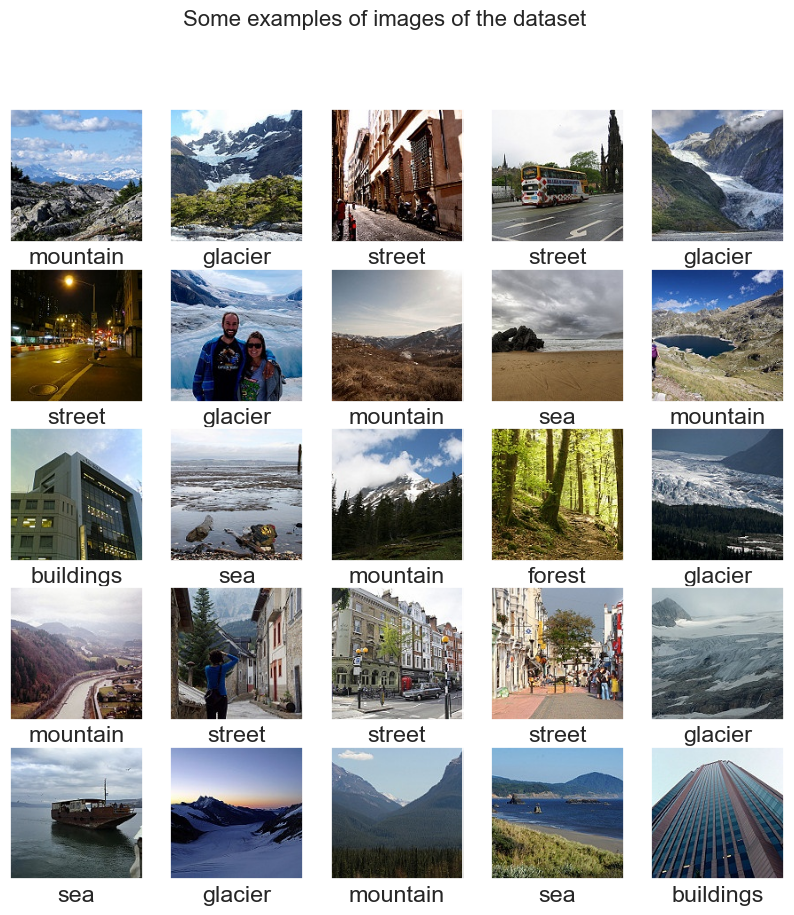

In [20]:
display_examples(class_names, train_images, train_labels)

# Beginner: Simple Model Creation

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [22]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [23]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 122s 1s/step - loss: 1.2151 - accuracy: 0.5313 - val_loss: 0.9248 - val_accuracy: 0.6541
Epoch 2/20
88/88 [==============================] - 123s 1s/step - loss: 0.7801 - accuracy: 0.7161 - val_loss: 0.9796 - val_accuracy: 0.6530
Epoch 3/20
88/88 [==============================] - 124s 1s/step - loss: 0.6001 - accuracy: 0.7851 - val_loss: 0.7049 - val_accuracy: 0.7449
Epoch 4/20
88/88 [==============================] - 116s 1s/step - loss: 0.4723 - accuracy: 0.8297 - val_loss: 0.7360 - val_accuracy: 0.7431
Epoch 5/20
88/88 [==============================] - 116s 1s/step - loss: 0.3349 - accuracy: 0.8857 - val_loss: 0.6749 - val_accuracy: 0.7738
Epoch 6/20
88/88 [==============================] - 115s 1s/step - loss: 0.2217 - accuracy: 0.9305 - val_loss: 0.7703 - val_accuracy: 0.7649
Epoch 7/20
88/88 [==============================] - 115s 1s/step - loss: 0.1544 - accuracy: 0.9535 - val_loss: 0.7941 - val_accuracy: 0.7727
Epoch 8/20
88

In [30]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

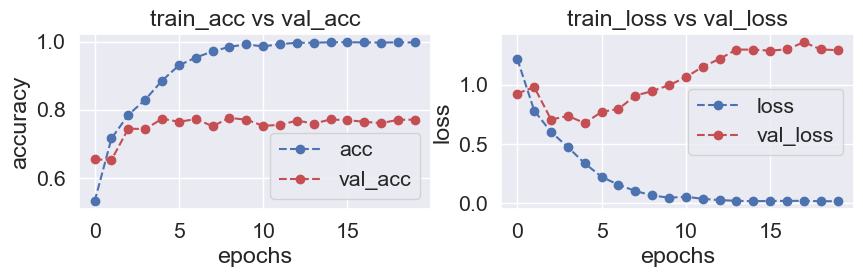

In [31]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [32]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 67ms/step - loss: 1.2526 - accuracy: 0.7740


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

94/94 [==============================] - 212s 2s/step


TypeError: only integer scalar arrays can be converted to a scalar index

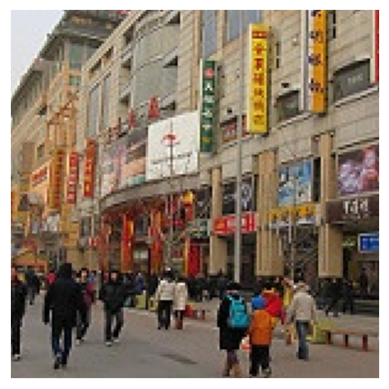

In [61]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [36]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


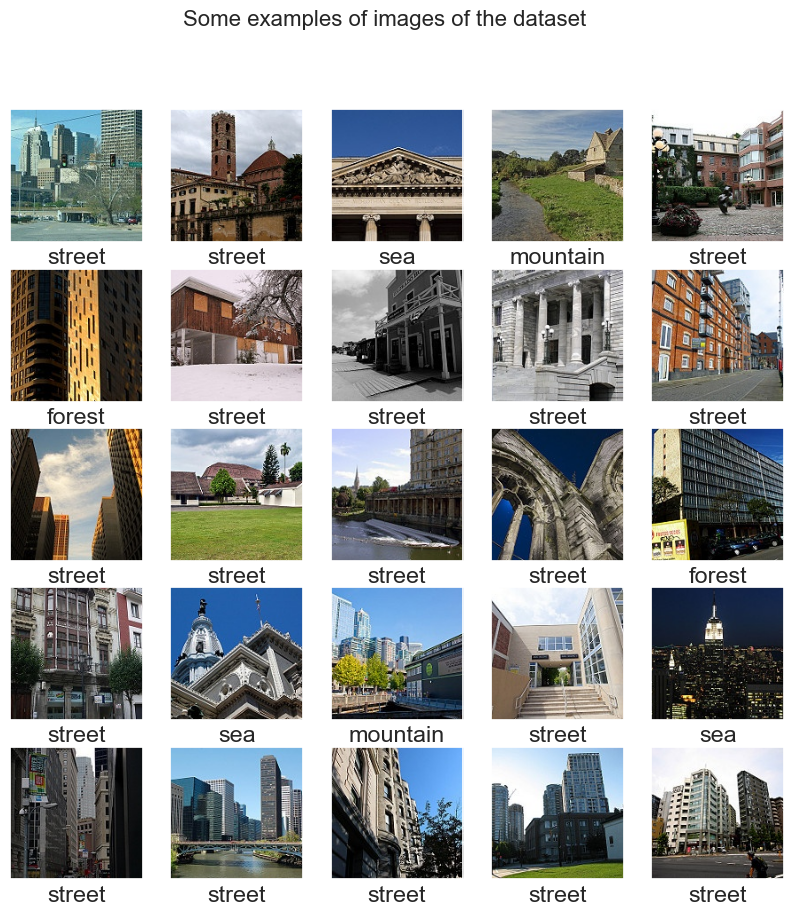

In [37]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

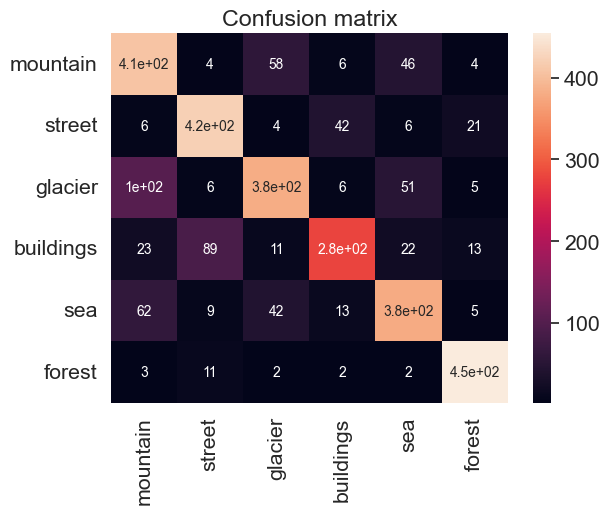

In [38]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them.
However, it can detects forest very accurately!

**Intermediate Update January 2020**

* Feature extraction with VGG16 trained on ImageNet


* Ensemble models of Neural Networks with the features extracted from VGG

Inspired from: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

* Fine Tuning with VGG16 trained on ImageNet

# Feature extraction with VGG ImageNet

We can extract features from VGG16.

In [39]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


Get the features directly from VGG16

In [40]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 228s 2s/step


## Visualize the features through PCA

In [42]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [43]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

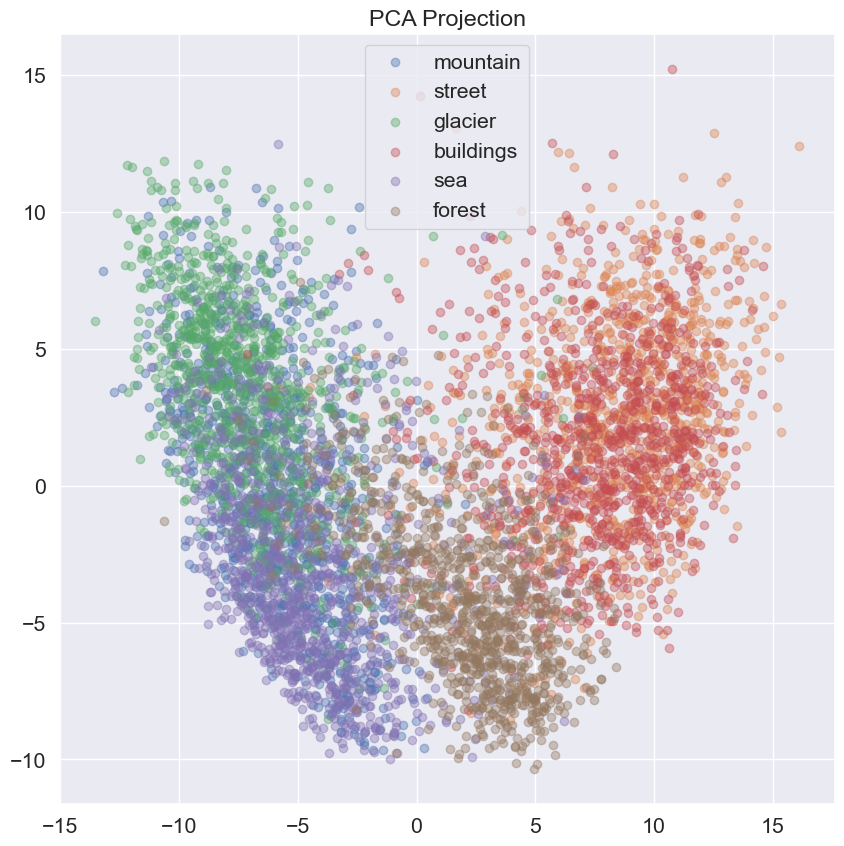

In [44]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We can identifying clusters thanks to this PCA. The clusters correspond more or less to the labels.

We see that glacier and mountain points are very close to each other, as VGG sees them as very similar.

We see that there is no distinction between building and street.
 

## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [45]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 11ms/step - loss: 0.5186 - accuracy: 0.8105 - val_loss: 0.3499 - val_accuracy: 0.8650
Epoch 2/15
88/88 [==============================] - 1s 11ms/step - loss: 0.3105 - accuracy: 0.8901 - val_loss: 0.3281 - val_accuracy: 0.8764
Epoch 3/15
88/88 [==============================] - 1s 10ms/step - loss: 0.2522 - accuracy: 0.9102 - val_loss: 0.3151 - val_accuracy: 0.8871
Epoch 4/15
88/88 [==============================] - 1s 10ms/step - loss: 0.1958 - accuracy: 0.9312 - val_loss: 0.3473 - val_accuracy: 0.8771
Epoch 5/15
88/88 [==============================] - 1s 11ms/step - loss: 0.1635 - accuracy: 0.9465 - val_loss: 0.3184 - val_accuracy: 0.8853
Epoch 6/15
88/88 [==============================] - 1s 13ms/step - loss: 0.1452 - accuracy: 0.9495 - val_loss: 0.3294 - val_accuracy: 0.8821
Epoch 7/15
88/88 [==============================] - 1s 10ms/step - loss: 0.1214 - accuracy: 0.9591 - val_loss: 0.3498 - val_accuracy: 0.8835
Epoch 8/15
88

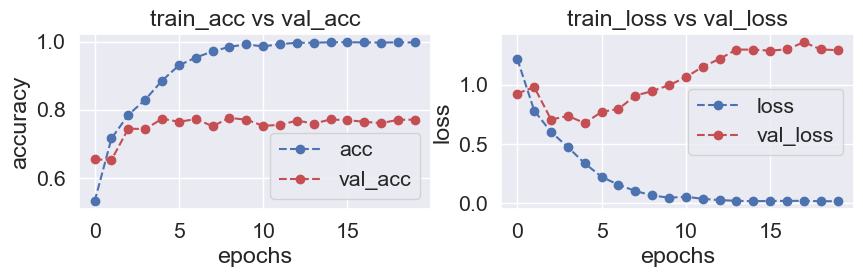

In [46]:
plot_accuracy_loss(history)

We should get approximately 0.844 accuracy (+0.1 accuracy) over the simple ConvNet.

In [47]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.8807


# Ensemble Neural Networks

In [48]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks. 

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [49]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [50]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 1s 13ms/step - loss: 0.5435 - accuracy: 0.7974 - val_loss: 0.3191 - val_accuracy: 0.8914
Epoch 2/10
79/79 [==============================] - 1s 14ms/step - loss: 0.2538 - accuracy: 0.9149 - val_loss: 0.2584 - val_accuracy: 0.9136
Epoch 3/10
79/79 [==============================] - 1s 12ms/step - loss: 0.1872 - accuracy: 0.9388 - val_loss: 0.2230 - val_accuracy: 0.9243
Epoch 4/10
79/79 [==============================] - 1s 12ms/step - loss: 0.1439 - accuracy: 0.9555 - val_loss: 0.2419 - val_accuracy: 0.9065
Epoch 5/10
79/79 [==============================] - 1s 13ms/step - loss: 0.1132 - accuracy: 0.9658 - val_loss: 0.1889 - val_accuracy: 0.9412
Epoch 6/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0861 - accuracy: 0.9776 - val_loss: 0.1982 - val_accuracy: 0.9341
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0678 - accuracy: 0.9846 - val_loss: 0.2137 - val_accuracy: 0.9297
Epoch 8/10
79

We aggregate each model individual predictions to form a final prediction.

In [51]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

94/94 [==============================] - 0s 2ms/step


We should improve our result as we have a lower variance.

In [52]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8876666666666667


# Fine Tuning VGG ImageNet

In [53]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [54]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 216s 2s/step


In [55]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [56]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0   

In [58]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 254s 3s/step - loss: 0.5995 - accuracy: 0.7719 - val_loss: 0.3878 - val_accuracy: 0.8593
Epoch 2/10
88/88 [==============================] - 256s 3s/step - loss: 0.3155 - accuracy: 0.8860 - val_loss: 0.3148 - val_accuracy: 0.8924
Epoch 3/10
88/88 [==============================] - 256s 3s/step - loss: 0.2337 - accuracy: 0.9201 - val_loss: 0.2479 - val_accuracy: 0.9131
Epoch 4/10
88/88 [==============================] - 255s 3s/step - loss: 0.1909 - accuracy: 0.9307 - val_loss: 0.2801 - val_accuracy: 0.9042
Epoch 5/10
88/88 [==============================] - 255s 3s/step - loss: 0.1618 - accuracy: 0.9414 - val_loss: 0.2927 - val_accuracy: 0.9116
Epoch 6/10
88/88 [==============================] - 254s 3s/step - loss: 0.1280 - accuracy: 0.9545 - val_loss: 0.4008 - val_accuracy: 0.8917
Epoch 7/10
88/88 [==============================] - 257s 3s/step - loss: 0.1275 - accuracy: 0.9542 - val_loss: 0.3230 - val_accuracy: 0.9013
Epoch 8/10
88

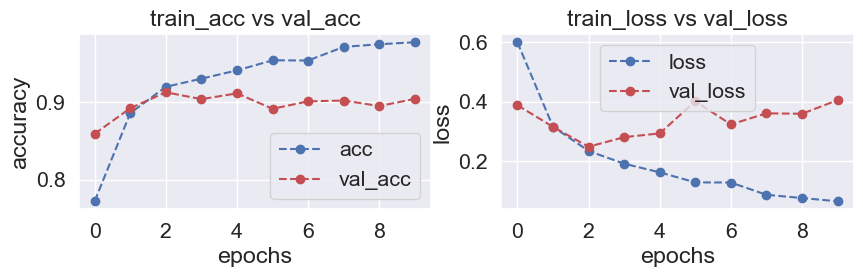

In [59]:
plot_accuracy_loss(history)

In [60]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 13s 137ms/step
Accuracy : 0.903
